Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Part 1: The seven scientists

This example is due to [MacKay 2003, exercise 22.15] and [Lee & Wagenmaker 2013, section 4.2].

Suppose seven scientists all go and perform the same experiment, each collecting a measurement $x_i$ for $i = 1,\dots,7$, of an underlying physical value $\mu$. 
 
These scientists are varyingly good at their job, and while we can assume each scientist would estimate $\mu$ correctly _on average_, some of them may have much more error in their measurements than others.

They come back with the following seven observations:


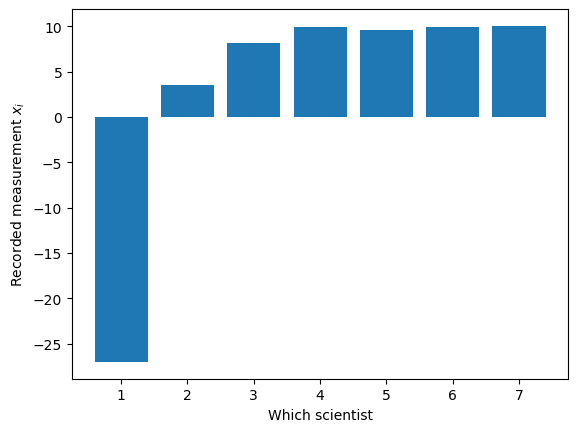

In [3]:
measurements = torch.FloatTensor([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])

plt.bar(np.arange(1,8), measurements) # , "o")
plt.xlabel("Which scientist")
plt.ylabel("Recorded measurement $x_i$");

From looking at the plot, clearly one scientist does not know what they are doing (and some of the others are probably a little suspect too)!


### A model for the data

In this exercise we will suppose that there is "scientist-specific" standard deviation $\sigma_i$, which describes how accurately each of them might perform the experiment:

$$\begin{align}
x_i &\sim \mathrm{Normal}(\mu, \sigma_i^2).
\end{align}$$

Scientists with low $\sigma_i$ produce good estimates of $x$, whereas scientists with high $\sigma_i$ might have wildly inaccurate estimates. However, we don't know _which_ scientists are good -- and we only have one observation from each!

We can ask two questions:

* What is the "real" value of $\mu$?
* What are the values of $\sigma_i$ for each scientists?



### Bayesian inference approach

You will have to choose priors for the mean $\mu$ of the measurements, and for the error standard deviation $\sigma\_i$ for each of the $i$ scientists. A good starting point is

$$\begin{align}
\mu &\sim \mathrm{Normal}(0, \alpha^2) \\
\sigma_i &\sim \mathrm{Exponential}(\beta)
\end{align}$$

where $\alpha=50$ and $\beta=0.5$. This is a prior distribution with mean 2 that places diminishing probability density on larger values of $\sigma_i$:


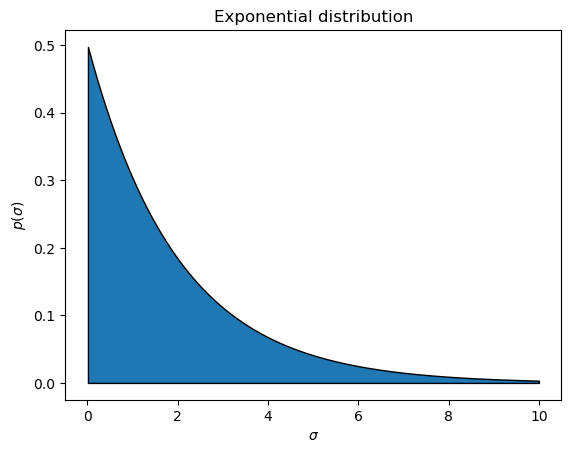

In [4]:
plt.fill_between(np.linspace(0.01,10,100), 0.0, 
                 dist.Exponential(rate=0.5).log_prob(torch.linspace(0.01,10,100)).exp(), 
                 edgecolor='k');
plt.xlabel("$\sigma$")
plt.ylabel("$p(\sigma)$")
plt.title("Exponential distribution");

# TASK #1 (3 points): Define the model

Given $\alpha=50, \beta=0.5$, and the measurements $x$ above, write a function to compute the unnormalized log density

$$\log p(\mu, x_1,\dots,x_7, \sigma_1,\dots, \sigma_7 | \alpha, \beta)$$

In [5]:
def log_joint(mu, sigma, alpha=50, beta=0.5):
    
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    log_joint: the log probability log p(mu, sigma, x | alpha, beta), scalar
    
    NOTE: For inputs where sigma <= 0, please return negative infinity!

    """
    assert mu.ndim == 0
    assert sigma.shape == (7,)
    
    # YOUR CODE HERE
    if torch.any(sigma <= 0):
        return -torch.inf  # Return negative infinity as request
    
    # Prior for mu: p(mu) = Normal(0, alpha^2) 
    log_p_mu = dist.Normal(0, alpha).log_prob(mu)
    # Prior for sigma: Exponential(beta)
    log_p_sigma = dist.Exponential(beta).log_prob(sigma).sum()
    # Likelihood
    log_p_x = dist.Normal(mu, sigma).log_prob(measurements).sum()
    # Based on def of joint prob, we multiply all the term. In log, we replace multiply with addition.
    log_joint = log_p_mu + log_p_sigma + log_p_x
    
    return log_joint
    

#### Ignore the following cells. 

They consist of "hidden" test cases, and are used by the grading system.

In [6]:
# (GRADING)

In [7]:
# (GRADING)

# TASK #2 (5 points): Implement an MCMC sampler

Your second task is to implement an MCMC algorithm to sample from the posterior distribution

$$p(\mu, \sigma | x, \alpha, \beta).$$

To do this, you need to implement two functions:

* `get_mcmc_proposal`: this takes in current values of $\mu$ and $\sigma$, and returns pytorch `Distribution` objects (i.e., `torch.distributions.Distribution`, here in-scope as `dist.Distribution`) that will propose a next value given the current value, $q(\mu' | \mu, \dots)$ and $q(\sigma' | \sigma, \dots)$. It is **your choice** what sort of distribution to use here! Just make sure that whatever you propose works well in your MCMC algorithm.

* `mcmc_step`: this takes in current values of $\mu$ and $\sigma$, and runs a single Metropolis-Hastings step:
  1. sample candidate values from the proposal distribution you defined
  2. compute an acceptance probability, and either accept or reject
  3. return $\mu, \sigma$

In [51]:
def get_mcmc_proposal(mu, sigma):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0

    OUTPUT:
    q_mu    : instance of Distribution class, that defines a proposal for mu
    q_sigma : instance of Distribution class, that defines a proposal for sigma
    """
    
    # YOUR CODE HERE
    # Standard deviations for proposal distributions
    std_mu = 0.6      # we have varied std_mu from 1 to 0.5
    std_sigma = 0.2 # we have varided std_log_sigma from 0.1 to 0.1

    # Proposal distribution for mu: Normal centered at current mu
    q_mu = dist.Normal(mu, std_mu)

    # Proposal distribution for sigma: Normal centered at sigma
    q_sigma = dist.Normal(sigma, std_sigma) 

    return q_mu, q_sigma



### Quick self-check!

If your `get_mcmc_proposal` has the correct function signature, all the following assertions should be true:

In [9]:
q_mu, q_sigma = get_mcmc_proposal(torch.tensor(9.0), torch.ones(7))
assert isinstance(q_mu, dist.Distribution)
assert isinstance(q_sigma, dist.Distribution)
assert q_mu.sample().shape == ()
assert q_sigma.sample().shape == (7,)
del q_mu, q_sigma

In [10]:
def mcmc_step(mu, sigma, alpha=50, beta=0.5):
    """
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    mu       : the next value of mu in the MCMC chain
    sigma    : the next value of sigma in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted

    """
    
    accepted = False
    q_mu, q_sigma = get_mcmc_proposal(mu, sigma)
    
    # YOUR CODE HERE
    # Sample the proposal distribution as the candidate for next step 
    mu_candidate = q_mu.sample()
    sigma_candidate = q_sigma.sample()

    # Compute the log joint probabilities for current step and candidate step
    log_p_current = log_joint(mu, sigma, alpha, beta)
    log_p_candidate = log_joint(mu_candidate, sigma_candidate, alpha, beta)

    # Compute log proposal probabilities
    # For mu, we have q(mu'|mu) where mu' = mu_candidate, q_mu is the proposal distribution
    # Also, we set the default choice as Normal distribution which will cancel out due to symmetric property
    # To keep the form of equation, we show the original form: q(mu|mu')/q(mu'|mu) 
    log_q_mu_forward = q_mu.log_prob(mu_candidate)
    # To find q(mu'|mu), we need proposal distribution for mu_candidate
    q_mu_candidate, q_sigma_candidate = get_mcmc_proposal(mu_candidate, sigma_candidate)
    # Here is q(mu|mu')
    log_q_mu_backward = q_mu_candidate.log_prob(mu)

    # Similar for sigma
    # q(sigma'|sigma)
    log_q_sigma_forward = q_sigma.log_prob(sigma_candidate).sum()
    # q(sigma|sigma')
    log_q_sigma_backward = q_sigma_candidate.log_prob(sigma).sum()

    # Compute the log acceptance ratio: p(y,x')/p(y,x) * q(mu|mu')/q(mu'|mu) * q(sigma|sigma')/q(sigma'|sigma)
    # Taking log, '/' --> '-' and '*' --> '+'
    log_accept_ratio = ((log_p_candidate - log_p_current) + (log_q_mu_backward - log_q_mu_forward) + (log_q_sigma_backward - log_q_sigma_forward))
    # log_accept_ratio = log_p_candidate - log_p_current
    # Convert log accept_ratio back  
    accept_ratio = torch.exp(log_accept_ratio).clamp(max=1.0).item()

    # Here, we introduce a random number that makes the acceptance process be random. 'Maybe move to next step'
    u = torch.rand(1).item()
    if u < accept_ratio:
        # Accept the candidate
        mu = mu_candidate
        sigma = sigma_candidate
        accepted = True
    else:
        # Reject the candidate
        # mu and sigma remain unchanged
        accepted = False
    

    return mu, sigma, accepted
    # return mu, sigma, accepted

## Running MCMC

We've supplied the outer loop for you -- it will call and execute your `mcmc_step` function. You should *not* need to edit it!

You do need to fill in the function `algo_parameters`, though, which just returns the total number of iterations you decide to run the MCMC chain, and the number of samples to discard as "burnin".

In [11]:
def run_mcmc(N_iters, mu_init, sigma_init):
    """ Run an MCMC algorithm for a fixed number of iterations """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    N_accepted = 0
    for _ in range(N_iters):
        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
        N_accepted += accepted
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), N_accepted / N_iters

In [12]:
def algo_parameters():
    """ TODO: set these to appropriate values:
    
    OUTPUT:
    N_samples : total number of MCMC steps
    N_burnin  : number of initial steps to discard
    """
    
    # YOUR CODE HERE

    
    N_samples = 10000
    N_burnin = 1000
    return N_samples, N_burnin

## Initialize, run, and display diagnostics

The following code initializes the MCMC sampler, executes it for the number of iterations you specified, and then plots a handful of diagnostics.

Use these diagnostics to decide whether or not you have done this properly! Take some time to try to interpret the results, and feel free to play around with the plots a bit.

In [52]:
mu_init = measurements.mean()
sigma_init = torch.ones(7)

N_samples, N_burnin = algo_parameters()

mu_chain, sigma_chain, accepted = run_mcmc(N_samples, mu_init, sigma_init)
print("acceptance rate:", accepted) 

acceptance rate: 0.2045


## Invesitigate the relations between standard deviation and acceptance rate
It costs time. So we block this part.

In [48]:
'''
# Here we try to find the relation between acceptance and std
# Range of s_mu values
s_mu_values = np.linspace(0.1, 2.0, 20)

# Range of s_log_sigma values
s_log_sigma_values = np.linspace(0.01, 0.5, 20)


acceptance_rates_mu = []
fixed_s_log_sigma = torch.full((7,), 0.1)  # Fixed value for s_log_sigma

for s_mu in s_mu_values:
    acceptance_rate = run_mcmc(N_samples, mu_init, sigma_init)[2]
    acceptance_rates_mu.append(acceptance_rate)

# Plotting the results
import matplotlib.pyplot as plt

plt.plot(s_mu_values, acceptance_rates_mu, marker='o')
plt.title('Acceptance Rate vs s_mu')
plt.xlabel('s_mu (Proposal Std Dev for μ)')
plt.ylabel('Acceptance Rate')
plt.grid(True)
plt.show()
'''

"\n# Here we try to find the relation between acceptance and std\n# Range of s_mu values\ns_mu_values = np.linspace(0.1, 2.0, 20)\n\n# Range of s_log_sigma values\ns_log_sigma_values = np.linspace(0.01, 0.5, 20)\n\n\nacceptance_rates_mu = []\nfixed_s_log_sigma = torch.full((7,), 0.1)  # Fixed value for s_log_sigma\n\nfor s_mu in s_mu_values:\n    acceptance_rate = run_mcmc(N_samples, mu_init, sigma_init)[2]\n    acceptance_rates_mu.append(acceptance_rate)\n\n# Plotting the results\nimport matplotlib.pyplot as plt\n\nplt.plot(s_mu_values, acceptance_rates_mu, marker='o')\nplt.title('Acceptance Rate vs s_mu')\nplt.xlabel('s_mu (Proposal Std Dev for μ)')\nplt.ylabel('Acceptance Rate')\nplt.grid(True)\nplt.show()\n"

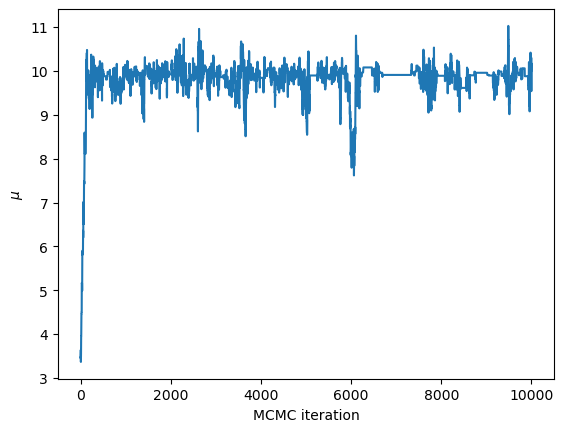

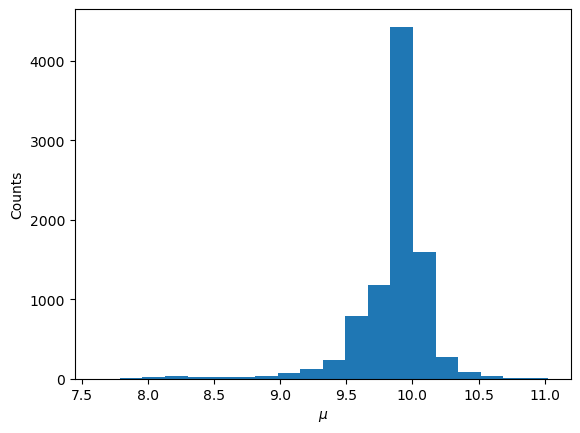

In [49]:
plt.plot(mu_chain);
plt.xlabel("MCMC iteration");
plt.ylabel("$\mu$")
plt.figure();
plt.hist(mu_chain[N_burnin:].numpy(), bins=20);
plt.xlabel("$\mu$")
plt.ylabel("Counts");

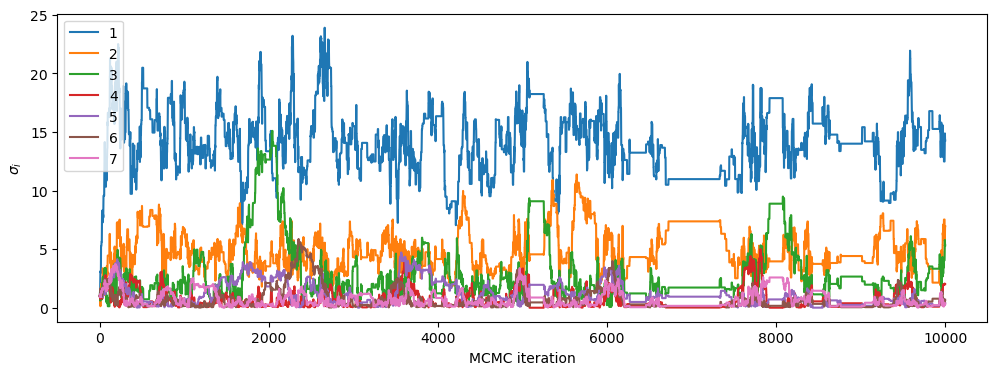

In [50]:
plt.figure(figsize=(12,4));
plt.plot(sigma_chain)
plt.legend(range(1,8));
plt.xlabel("MCMC iteration")
plt.ylabel("$\sigma_i$");

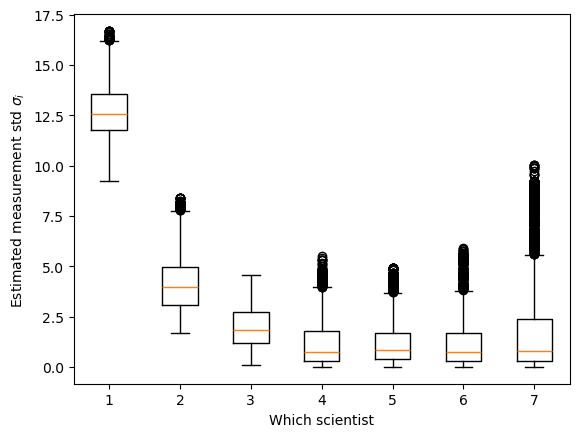

In [37]:
plt.boxplot(sigma_chain[N_burnin:], positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

# TASK #3 (2 points): Estimate posterior expectations

We're specifically interested in using the samples to answer the following:

1. What is the expected value of $\mu$, i.e., $\mathbb{E}[\mu ]$, under the posterior distribution?
2. What is the posterior probability that $\mu$ is less than 9, i.e. $\Pr(\mu < 9.0)$?

Both of these questions can be answered by using samples from your MCMC chain.

In [18]:
def estimate_E_mu(mu_chain, sigma_chain, N_burnin):
    """ Estimate E[mu] 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    mu : expected value of mu (scalar)
    """
    
    # YOUR CODE HERE
    # Discard burn-in samples
    mu_samples = mu_chain[N_burnin:]
    
    # Compute the mean of mu_samples
    mu_estimate = mu_samples.mean()
    
    return mu_estimate
    
def estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin):
    """ Estimate the posterior probability that mu is less than 9, i.e. Pr(mu < 9) 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    estimate : estimate of Pr(mu < 9), a scalar
    """
    
    # YOUR CODE HERE
    # Discard burn-in samples
    mu_samples = mu_chain[N_burnin:]
    
    # Compute the number of samples where mu < 9
    count = (mu_samples < 9.0).sum()
    
    # Total number of samples after burn-in
    total_samples = len(mu_samples)
    
    # Estimate the probability
    estimate = count / total_samples
    
    return estimate

In [19]:
print("E[mu] = %0.4f" % estimate_E_mu(mu_chain, sigma_chain, N_burnin))
print("Pr(mu < 9) = %0.4f" % estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin))

E[mu] = 9.7321
Pr(mu < 9) = 0.0438


# SHORT ANSWER SECTION (4 points)

Please answer the following 2 questions, for up to two points each:

1. Describe your choices of MCMC proposal distributions. How did you select them? How do you know they are "good"?
2. In your `mcmc_step`, we consider 8 random variables, $\mu, \sigma_1, \dots, \sigma_7$, but you probably implemented this using a single accept-reject step (i.e., you propose new values for all random variables, and then jointly accept all of them, or not). Suppose someone suggested instead proposing for each of these variables one-at-a-time sequentially, including a separate accept-reject step after each. Might this be a good idea, and why or why not?

YOUR ANSWER HERE
### Question 1 
For $\mu$ and $\sigma$, the proposal distributions are Normal distribution.
$$ q(\mu' \mid \mu) = \mathcal{N}(\mu, s_\mu^2) $$ 
Since it covers the range of target distribution. Also, it is a symmetric proposal distributions which would simplify the acceptance ratio and make the computation process stable and easier. 


Here's the improved response using LaTeX block notation with `$$` for equations:

---

**Question 1**  
For $\mu$ and $\sigma$, the proposal distributions are chosen as Normal distributions:

$$
q(\mu' \mid \mu) = \mathcal{N}(\mu, s_{\mu}^2)
$$

where $s_{\mu}$ is the standard deviation of the proposal distribution for $\mu$. Similarly,$\sigma$ follows:

$$
q(\sigma' \mid \sigma) = \mathcal{N}(\sigma, s_{\sigma}^2)
$$

These choices are based on the fact that Normal distributions allow us to explore the parameter space effectively and symmetrically around the current values, which simplifies the Metropolis acceptance ratio. The symmetry of the proposal distributions also makes the acceptance ratio straightforward to calculate since it only depends on the target distribution ratios.

The effectiveness of these choices is verified by observing the acceptance rate. After tuning $(s_{\mu})$ and \($s_{\sigma}$\), we find that the acceptance rate lies between 20\% and 30\%, which is generally considered a good range for MCMC efficiency. This indicates that the proposal distributions are appropriate, as they balance exploration and acceptance probability without causing overly high rejection rates or inefficient sampling.

**Question 2**  
In the current MCMC setup, we jointly propose new values for all eight random variables and perform a single accept-reject step for the entire set. This approach has the advantage of simplicity and may allow for faster convergence if the variables are strongly correlated because it updates them together. However, there are potential downsides, as it might lead to lower acceptance rates if the joint proposal often deviates significantly from the target distribution.

If we instead propose new values for each variable one-at-a-time and include a separate accept-reject step for each proposal, this could improve the mixing of the Markov chain. By updating each variable sequentially, the chain can make more gradual adjustments, which could lead to a higher acceptance rate for individual steps, potentially increasing the overall sampling efficiency. This approach also allows each variable's proposal distribution to be more finely tuned independently, which may help in cases where variables have very different scales or sensitivities.

However, the downside of the one-at-a-time approach is that it can be computationally more expensive, as it requires multiple accept-reject checks per iteration. Additionally, if the variables are highly correlated, updating them sequentially may slow down convergence because it breaks the natural correlations.

In summary, proposing one variable at a time could improve mixing and acceptance rates in scenarios with poorly tuned joint proposals or low acceptance rates, while joint updates are often more efficient for highly correlated variables. The choice depends on the trade-off between computational cost and the specific characteristics of the target distribution.


#### Ignore the following cells. They are used by the grading system.

In [20]:
# (GRADING)

In [21]:
# (GRADING)

In [22]:
# (GRADING)

In [23]:
# (GRADING)

In [24]:
# (GRADING)

# EXTRA CREDIT TASK #4 (2 points): Estimate $\alpha$ and $\beta$

Did we choose the hyperparameters $\alpha$ and $\beta$ well? Or were these poor selections?

One way of checking whether $\alpha$ and $\beta$ are set well is by computing a marginal likelihood estimate, i.e. estimating $p(x | \alpha, \beta)$ for different choices of $\alpha, \beta$.

However, a different option is to *also* perform Bayesian inference over $\alpha$ and $\beta$! To do this, we need to do three things:

1. Define a prior $p(\alpha, \beta)$
2. Define MCMC proposals $q(\alpha' | \alpha)$ and $q(\beta' | \beta)$
3. Update the MCMC algorithm itself to also sample $\alpha, \beta$.

To do this, this involves targeting the joint probability distribution

$$p(x,\mu,\sigma,\alpha,\beta) = p(x | \mu, \sigma)p(\mu | \alpha)p(\sigma | \beta)p(\alpha)p(\beta).$$

You can write your MCMC algorithm so that it alternates between doing updates on $\mu, \sigma$ (using your existing `mcmc_step` function) and doing updates on $\alpha, \beta$ (using a new `mcmc_step_hyperparams` function).

To do this you need to implement two things:

1. `log_prior_alpha_beta`: given $\alpha,\beta$, return $\log p(\alpha, \beta)$. You are free to define whatever sort of prior you think is appropriate.
2. `mcmc_step_hyperparams`: do a single MCMC step (including accept / reject) to update $\alpha, \beta$.

These will then be called by the `run_mcmc_bonus` function, below.

In [25]:
def log_prior_alpha_beta(alpha, beta):
    """
    Define a prior distribution on alpha, beta, and return its log probability
    
    INPUT:
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    log_prob : scalar, `log p(alpha, beta)`
    
    """
    
    # YOUR CODE HERE
    if beta < 0 or beta > 50:
        return -np.inf
    log_p_alpha = dist.Normal(50, 1).log_prob(alpha)
    log_p_beta = dist.Normal(0.5, 0.2).log_prob(beta)
    return log_p_alpha + log_p_beta


In [26]:
def mcmc_step_hyperparams(mu, sigma, alpha, beta):
    """
    Run an MCMC step on alpha and beta
    
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    alpha    : the next value of alpha in the MCMC chain
    beta     : the next value of beta in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted
    
    """
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    # Proposal
    alpha_proposal = dist.Normal(alpha, 1)
    beta_proposal = dist.Normal(beta, 0.5)
    # Sample
    alpha_candidate = alpha_proposal.sample()
    beta_candidate = beta_proposal.sample()
    # p(alpha,beta) and p(alpha',beta')
    log_p_current = log_prior_alpha_beta(alpha, beta)
    log_p_candidate = log_prior_alpha_beta(alpha_candidate, beta_candidate)
    # Ratio
    log_accept_ratio = log_p_candidate - log_p_current
    # Convert log accept_ratio back  
    accept_ratio = torch.exp(log_accept_ratio).clamp(max=1.0).item()

    # Here, we introduce a random number that makes the acceptance process be random. 'Maybe move to next step'
    u = torch.rand(1).item()
    if u < accept_ratio:
        # Accept the candidate
        alpha = alpha_candidate
        beta = beta_candidate
        accepted = True
    else:
        # Reject the candidate
        # mu and sigma remain unchanged
        accepted = False
    return alpha, beta, accepted
    



### Run this MCMC algorithm, and plot the results.

What do you think?

1. Are these results qualitatively different?
2. Were the original choices of $\alpha, \beta$ reasonable?
3. How sensitive are these results to $\alpha, \beta$? To $p(\alpha, \beta)$?

In [27]:
def run_mcmc_bonus(N_iters, mu_init, sigma_init, alpha_init, beta_init):
    """ Run an MCMC algorithm for a fixed number of iterations.
    
    This also runs MCMC on "hyperparameters" alpha and beta.
    
    """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    alpha_chain = [alpha_init]
    beta_chain = [beta_init]
    for _ in range(N_iters):
        alpha, beta, accepted = mcmc_step_hyperparams(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        alpha_chain.append(alpha)
        beta_chain.append(beta)

        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), torch.stack(alpha_chain), torch.stack(beta_chain)

In [28]:
new_mu_chain, new_sigma_chain, alpha_chain, beta_chain = run_mcmc_bonus(N_samples, mu_chain[-1], sigma_chain[-1], torch.tensor(50.0), torch.tensor(0.5))

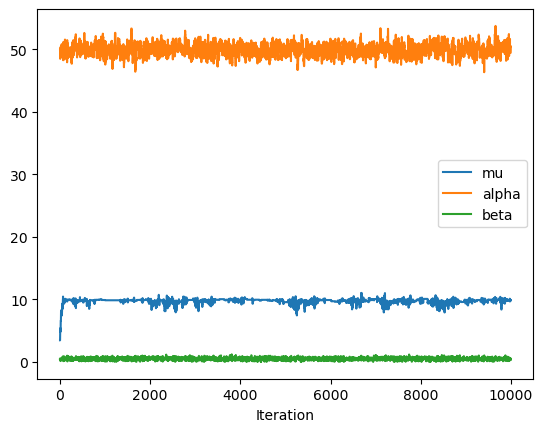

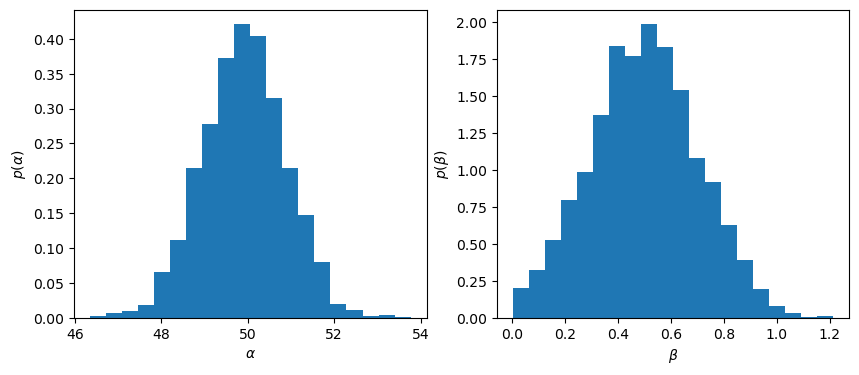

In [29]:
plt.plot(mu_chain)
plt.plot(alpha_chain);
plt.plot(beta_chain);
plt.legend(['mu', 'alpha', 'beta']);
plt.xlabel("Iteration");
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(alpha_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\alpha$")
plt.ylabel("$p(\\alpha)$")
plt.subplot(122)
plt.hist(beta_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\beta$")
plt.ylabel("$p(\\beta)$");

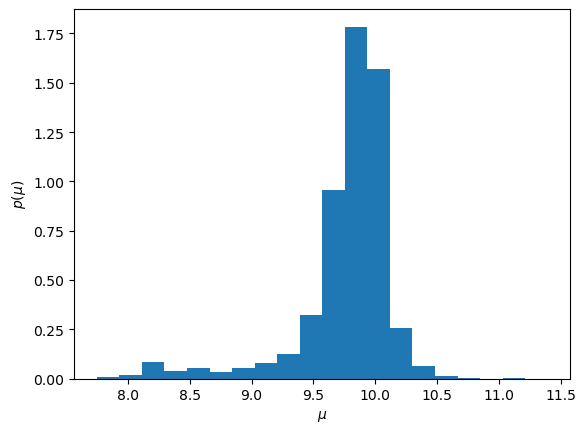

In [30]:
plt.hist(new_mu_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu)$");

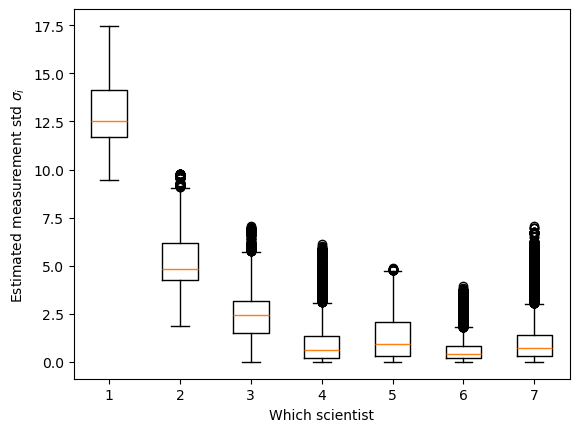

In [31]:
plt.boxplot(new_sigma_chain[N_burnin:], positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

In [32]:
# (GRADING)

In [33]:
# (GRADING)